In [7]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import torch.nn.functional as F

# --- Hyperparameters ---
NUM_NODES = 50       # Number of segments in our 1D rod
TIME_STEPS = 100     # Number of time steps to simulate
DT = 0.1             # Time step size (delta t)
ALPHA = 0.1          # Thermal diffusivity (physics constant)
LAMBDA_PHYSICS = 1.0 # Weight for the physics loss
EPOCHS = 2000        # Number of training epochs
LR = 1e-3            # Learning rate

In [8]:
# Create the edges for a 1D chain graph: node i is connected to i-1 and i+1
edge_list = []
for i in range(NUM_NODES - 1):
    edge_list.append([i, i + 1])
    edge_list.append([i + 1, i]) # Edges are bidirectional
edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()

# Set initial temperatures (node features)
# Hot spot in the middle, cool at the ends
initial_temps = torch.zeros(NUM_NODES, 1)
initial_temps[NUM_NODES // 2 - 5 : NUM_NODES // 2 + 5] = 100.0

# Create the PyG Data object
data = Data(x=initial_temps, edge_index=edge_index)

# For the data loss, let's pretend we have a sensor on Node 10
# We'll use a simple analytical solution for a single "ground truth" point
# This is just for demonstration; in a real case, this would be real data
ground_truth_node_idx = 10
ground_truth_temp_next_step = initial_temps[ground_truth_node_idx] # Assume it stays same for simplicity

In [9]:
class GNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(1, 16) # Input features=1 (temp), output=16
        self.conv2 = GCNConv(16, 1) # Input=16, output=1 (predicted temp)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

In [12]:
def physics_loss(model_output, initial_temps, edge_index):
    u_pred_next = model_output
    u_initial = initial_temps

    # 1. Calculate the time derivative: (u(t+Δt) - u(t)) / Δt
    du_dt = (u_pred_next - u_initial) / DT

    # 2. Calculate the Laplacian: ∇²u
    # For each node, sum the temperatures of its neighbors
    row, col = edge_index
    # We send messages from neighbors (col) to the central node (row)
    # This is a simple way to get the sum of neighbor values for each node
    neighbor_sum = torch.zeros_like(u_initial)
    neighbor_sum.index_add_(0, row, u_initial[col])

    # Get the degree (number of neighbors) for each node
    degree = torch.zeros_like(u_initial)
    ones = torch.ones_like(row, dtype=u_initial.dtype).unsqueeze(1) # Reshape 'ones' to have an extra dimension
    degree.index_add_(0, row, ones)
    degree[degree == 0] = 1 # Avoid division by zero for unconnected nodes

    laplacian = neighbor_sum - degree * u_initial

    # 3. Calculate the residual of the heat equation
    # The equation is ∂u/∂t - α * ∇²u = 0
    residual = du_dt - ALPHA * laplacian

    return torch.mean(residual**2)

In [13]:
model = GNN()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

print("Starting training...")
for epoch in range(EPOCHS):
    optimizer.zero_grad()

    # Get model prediction for the next time step
    predicted_temps = model(data)

    # Calculate Data Loss (on our single "sensor" node)
    data_loss = F.mse_loss(predicted_temps[ground_truth_node_idx], ground_truth_temp_next_step)

    # Calculate Physics Loss (on ALL nodes)
    phys_loss = physics_loss(predicted_temps, data.x, data.edge_index)

    # Combine the losses
    total_loss = data_loss + LAMBDA_PHYSICS * phys_loss

    total_loss.backward()
    optimizer.step()

    if epoch % 200 == 0:
        print(f"Epoch {epoch:04d} | Total Loss: {total_loss.item():.4f} | "
              f"Data Loss: {data_loss.item():.4f} | Physics Loss: {phys_loss.item():.4f}")

Starting training...
Epoch 0000 | Total Loss: 367051.0000 | Data Loss: 0.0000 | Physics Loss: 367051.0000
Epoch 0200 | Total Loss: 177344.9531 | Data Loss: 0.0734 | Physics Loss: 177344.8750
Epoch 0400 | Total Loss: 43240.8789 | Data Loss: 0.4721 | Physics Loss: 43240.4062
Epoch 0600 | Total Loss: 10475.3213 | Data Loss: 0.8635 | Physics Loss: 10474.4580
Epoch 0800 | Total Loss: 9236.4141 | Data Loss: 0.7923 | Physics Loss: 9235.6221
Epoch 1000 | Total Loss: 9195.3965 | Data Loss: 0.6150 | Physics Loss: 9194.7812
Epoch 1200 | Total Loss: 9161.7734 | Data Loss: 0.4483 | Physics Loss: 9161.3252
Epoch 1400 | Total Loss: 9128.3789 | Data Loss: 0.3000 | Physics Loss: 9128.0791
Epoch 1600 | Total Loss: 9096.0664 | Data Loss: 0.1772 | Physics Loss: 9095.8896
Epoch 1800 | Total Loss: 9065.5508 | Data Loss: 0.0847 | Physics Loss: 9065.4658



Simulation after training...


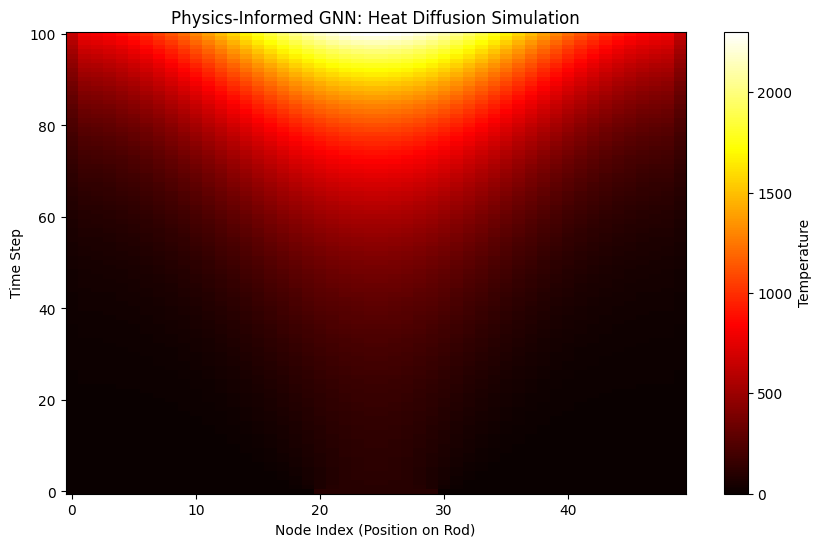

In [14]:
print("\nSimulation after training...")
with torch.no_grad():
    simulation_temps = [initial_temps.cpu().numpy()]
    current_temps = initial_temps.clone()

    for _ in range(TIME_STEPS):
        temp_data = Data(x=current_temps, edge_index=edge_index)
        # The model predicts the state at t+Δt
        next_temps = model(temp_data)
        current_temps = next_temps
        simulation_temps.append(current_temps.cpu().numpy())

# Plot the results as a heatmap
plt.figure(figsize=(10, 6))
plt.imshow(np.array(simulation_temps).squeeze(), aspect='auto', cmap='hot', origin='lower')
plt.colorbar(label="Temperature")
plt.xlabel("Node Index (Position on Rod)")
plt.ylabel("Time Step")
plt.title("Physics-Informed GNN: Heat Diffusion Simulation")
plt.show()